In [7]:
import torch
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from skorch import NeuralNetBinaryClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

from torchvision import datasets, transforms

from timeit import default_timer as timer
from datetime import datetime

# from prettytable import PrettyTable

print(f"PyTorch version: {torch.__version__}")
# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device 
# MPS backend did not end up working so will use cpu after all
device_name = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device_name}")

PyTorch version: 2.0.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [ ]:
# run once to download data set
# upload personal kaggle.json file to project root directory before executing this cell
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download pranavraikokte/covid19-image-dataset
! unzip covid19-image-dataset

In [8]:
# obtaining mean and std
# import data 

# local directory name
# data_dir = 'data'

# directory name obtained through api
data_dir = 'Covid19-dataset'
image_size = (224, 224)

data_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# create separate dataset and loader for calculating mean and std
train_data_calc = datasets.ImageFolder(data_dir + '/train', transform=data_transforms)
train_data_calc_loader = torch.utils.data.DataLoader(train_data_calc, batch_size=8, shuffle=True)

mean = 0.
std = 0.

for images, _ in train_data_calc_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_data_calc_loader.dataset)
std /= len(train_data_calc_loader.dataset)
print(mean)
print(std)

tensor([0.4954])
tensor([0.2713])


In [9]:
# transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
# mean and std values obtained from performing calculations on dataset :

# resize images to equal size, as each images varies in height and width
# apply random flip 
# converting to tensor scales image from [0, 255] to [0, 1], we want standard normalization

data_transforms = transforms.Compose([
    transforms.Resize(image_size),
    # transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean, std)
    # transforms.Normalize((mean, mean, mean), (std, std, std))
])

train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms)
test_dataset = datasets.ImageFolder(data_dir + '/test', transform=data_transforms)

Check train-test ratio

In [10]:
train_size = len(train_dataset.targets)
test_size = len(test_dataset.targets)
total_size = train_size + test_size
print("train / test ratio : {train:.2f}% \ {test:.2f}%".format(train = train_size / total_size, test =  test_size / total_size))

classes = train_dataset.classes
print(classes)

train / test ratio : 0.79% \ 0.21%
['Covid', 'Normal', 'Viral Pneumonia']


Show typical, normalized distribution of pixel values of a sample image

torch.Size([1, 224, 224])


Text(0.5, 1.0, 'distribution of pixels')

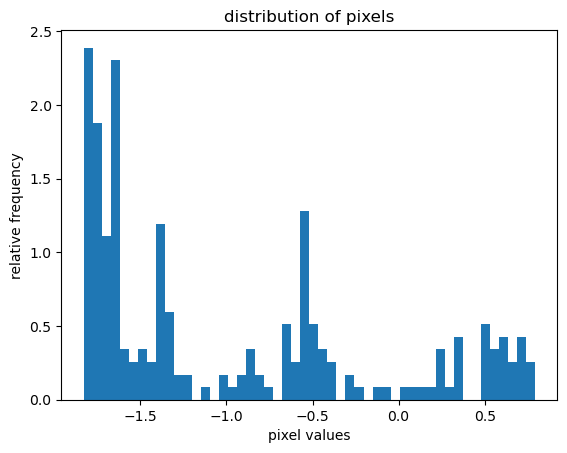

In [16]:
# show some sample data
np.random.seed(123)
idx = np.random.randint(0, 8)
dummy_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

images, labels = next(iter(dummy_data_loader))

first_image = images[idx]
print(first_image.shape)

plt.hist(first_image[0][0], bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

## Sample Images

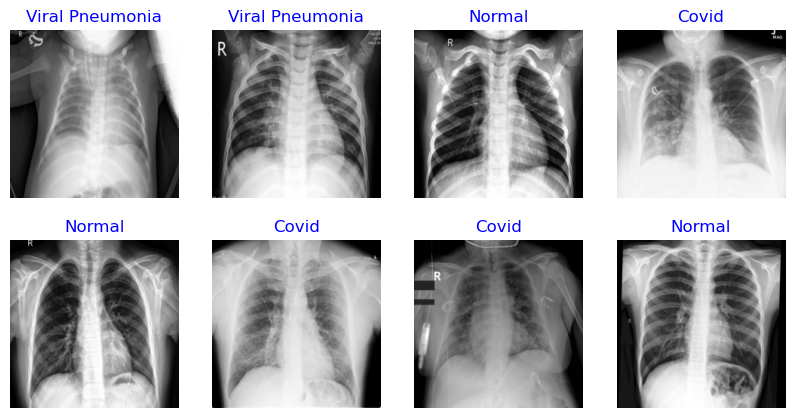

In [145]:
# use un-normalized data to show sample images, as normalized data will be clipped to [0,1]
images, labels = next(iter(train_data_calc_loader))

plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i]
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    index = labels[i]  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

## Model Architecture

In [154]:
channel_factor = 4
input_c = 1
out_c_1 = 4 * channel_factor
out_c_2 = 8 * channel_factor
out_c_3 = 16 * channel_factor
out_c_4 = 32 * channel_factor
out_c_5 = 64 * channel_factor

# not used
out_c_6 = 64 * channel_factor
out_c_7 = 128 * channel_factor


max_pooling_dim = 2
kernel_size_1 = 5
kernel_size_2 = 5
kernel_size_3 = 3
kernel_size_4 = 3
kernel_size_5 = 3

# not used
kernel_size_6 = 3
kernel_size_7 = 3

stride = 1
padding = 1
leaky_slope = 0.02 # default = 1e-2

input_size = 224
out_size_1 = (input_size - kernel_size_1 + 1 + 2 * padding) // max_pooling_dim
out_size_2 = (out_size_1 - kernel_size_2 +1 + 2 * padding) // max_pooling_dim
out_size_3 = (out_size_2 - kernel_size_3 + 1 + 2 * padding) // max_pooling_dim
out_size_4 = (out_size_3 - kernel_size_4 + 1 + 2 * padding) // max_pooling_dim
out_size_5 = (out_size_4 - kernel_size_5 + 1 + 2 * padding) // max_pooling_dim

# not used
out_size_6 = (out_size_5 - kernel_size_6 + 1 + 2 * padding) // max_pooling_dim
out_size_7 = (out_size_6 - kernel_size_7 + 1 + 2 * padding) // max_pooling_dim


fc_in = out_size_5 * out_size_5 * out_c_5
num_classes = len(classes)

fc_out_1 = 128
fc_out_2 = 64
fc_out_3 = num_classes

dropout_prob_1 = 0.5
dropout_prob_2 = 0.5

print(fc_in)

class CovidCNN(nn.Module):
    def __init__(self):
        super(CovidCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_c, out_c_1, kernel_size_1, stride, padding),
            nn.BatchNorm2d(out_c_1, momentum=0.9),
            nn.PReLU(out_c_1),
            # nn.ReLU(),
            nn.MaxPool2d(max_pooling_dim, max_pooling_dim)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(out_c_1, out_c_2, kernel_size_2, stride, padding),
            nn.BatchNorm2d(out_c_2, momentum=0.9),
            nn.PReLU(out_c_2),
            nn.MaxPool2d(max_pooling_dim, max_pooling_dim)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(out_c_2, out_c_3, kernel_size_3, stride, padding),
            nn.BatchNorm2d(out_c_3, momentum=0.9),
            nn.PReLU(out_c_3),
            nn.MaxPool2d(max_pooling_dim, max_pooling_dim)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(out_c_3, out_c_4, kernel_size_4, stride, padding),
            nn.BatchNorm2d(out_c_4, momentum=0.9),
            nn.PReLU(out_c_4),
            nn.MaxPool2d(max_pooling_dim, max_pooling_dim)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(out_c_4, out_c_5, kernel_size_5, stride, padding),
            nn.BatchNorm2d(out_c_5, momentum=0.9),
            nn.PReLU(out_c_5),
            nn.MaxPool2d(max_pooling_dim, max_pooling_dim)
        )

        # self.layer6 = nn.Sequential(
        #     nn.Conv2d(out_c_5, out_c_6, kernel_size_6, stride, padding),
        #     nn.BatchNorm2d(out_c_6),
        #     nn.PReLU(out_c_6),
        #     nn.MaxPool2d(max_pooling_dim, max_pooling_dim)
        # )

        # self.layer7 = nn.Sequential(
        #     nn.Conv2d(out_c_6, out_c_7, kernel_size_7, stride, padding),
        #     nn.BatchNorm2d(out_c_7),
        #     nn.PReLU(out_c_7),
        #     nn.MaxPool2d(max_pooling_dim, max_pooling_dim)
        # )

        self.fc1 = nn.Sequential(
            nn.Dropout(dropout_prob_1),
            nn.Linear(fc_in, fc_out_1),
            nn.PReLU(fc_out_1),
        )

        # self.fc2 = nn.Sequential(
        #     nn.Dropout(dropout_prob_2),
        #     nn.Linear(fc_out_1, fc_out_2),
        #     nn.PReLU(fc_out_2),
        # )

        self.fc3 = nn.Sequential(
            nn.Linear(fc_out_1, fc_out_3),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        # x = self.layer6(x)
        # x = self.layer7(x)
        
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        # x = self.fc2(x)
        output = self.fc3(x)
        
        return output

9216


## Training Loop

In [15]:

def train_loop(
    model,
    num_epochs,
    train_data_loader,
    train_size,
    val_data_loader,
    val_size,
    criterion,
    optimizer,
    scheduler,
    fold,
    perform_val=False):

    valid_loss_min = np.Inf
    valid_best_acc = 0
    history = []
    start_time = timer()

    model.train()
    best_epoch = 0

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        n_train_correct = 0
        n_valid_correct = 0
        
        for i, (images, labels) in enumerate(train_data_loader):
            # train
            images = images.to(device)
            labels = labels.to(device)

            batch_size = labels.size(0)
    
            # Forward pass
            outputs = model(images)
            # print(outputs)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
    
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_size

            _, predicted = torch.max(outputs, dim=1)
            n_train_correct += (predicted == labels).sum().item()

        train_acc = 100.0 * n_train_correct / train_size
        train_loss = train_loss / train_size

        if perform_val:
            # validate
            with torch.no_grad():
                model.eval()
                
                n_class_correct = [0 for i in range(num_classes)]
                n_class_samples = [0 for i in range(num_classes)]
                for images, labels in val_data_loader:
                    images = images.to(device)
                    labels = labels.to(device)
    
                    batch_size = labels.size(0)
                    
                    outputs = model(images)
    
                    loss = criterion(outputs, labels)
    
                    valid_loss += loss.item() * batch_size
                    # max returns (value ,index)
                    _, predicted = torch.max(outputs, dim=1)
                    n_valid_correct += (predicted == labels).sum().item()
                    
                    for i in range(batch_size):
                        label = labels[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1
            
                valid_acc = 100.0 * n_valid_correct / val_size
                valid_loss = valid_loss / val_size
    
                history.append([train_loss, valid_loss, train_acc, valid_acc])
            
                print(f'\nEpoch: {epoch + 1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {train_acc:.2f}%\t Validation Accuracy: {valid_acc:.2f}%')
    
                if (epoch + 1) == num_epochs:
                    for i in range(num_classes):
                        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                        print(f'Validation accuracy of {classes[i]}: {acc} %')
                    
                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch
            
        scheduler.step()
        
    time_elapsed = timer() - start_time

    if perform_val:
        print(f'\nFor fold {fold + 1}:\nBest epoch: {best_epoch} with loss: {valid_loss_min:.4f} and acc: {valid_best_acc:.2f}%')
    print(f'{time_elapsed:.2f} total seconds elapsed.')

    # return the final val loss and accuracy
    if perform_val:
        fold_metrics = [valid_loss, valid_acc]
    else:
        fold_metrics = [train_loss, train_acc]
   
    return model, history, fold_metrics

## Cross Validation Loop

In [17]:
def train_k_fold(
    n_folds,
    dataset,
    num_epochs,
    batch_size,
    learning_rate,
    momentum,
    step_size,
    gamma):

    total_history = [None] * n_folds
    total_fold_metrics = [None] * n_folds
    fold_histories = [None] * n_folds
    models = [None] * n_folds

    kfold = KFold(n_splits=n_folds, shuffle=True)
    
    for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):        

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
        test_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)

        train_data_loader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
        val_data_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler)

        model = CovidCNN().to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        # apply learning rate decay
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = lr_step_size, gamma=lr_gamma)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        # apply learning rate decay
        train_size = len(train_idxs)
        val_size = len(val_idxs)
        
        model, history, fold_metrics = train_loop(
            model=model,
            num_epochs=num_epochs,
            train_data_loader=train_data_loader,
            train_size=train_size,
            val_data_loader=val_data_loader,
            val_size=val_size,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            fold=fold,
            perform_val=True
        )

        fold_histories[fold] = history
        models[fold] = model

        # sum histories together to obtain average later
        if fold > 0:
            for i in range(len(total_history)):
                total_history[i] = [x + y for x, y in zip(total_history[i], history[i])]
            total_fold_metrics[0] += fold_metrics[0]
            total_fold_metrics[1] += fold_metrics[1]
            
        else:
            total_history = history
            total_fold_metrics = fold_metrics

    # divide metrics by number of folds 
    for i in range(len(total_history)):
        # each row contain 4 metrics
        for j in range(4):
            total_history[i][j] /= n_folds
    

    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {n_folds} FOLDS')
    print('--------------------------------')
    print(f'\nAverage Val Accuracy: {(total_fold_metrics[1] / n_folds):.2f}%\t Average Val Loss: {(total_fold_metrics[0] / n_folds):.4f}')

    total_history = pd.DataFrame(
        total_history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

    return total_history, fold_histories, models
    

## Hyperparameters

In [18]:
num_epochs = 24
batch_size = 16
learning_rate = 0.00075
momentum = 0.95
lr_step_size = 4
lr_gamma = 0.85
n_folds = 5

device = torch.device(device_name)

Visualize and compare different learning rate schedulers' decays

/Users/alexlassooij/miniconda3/envs/cpen355/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


(0.0, 0.001)

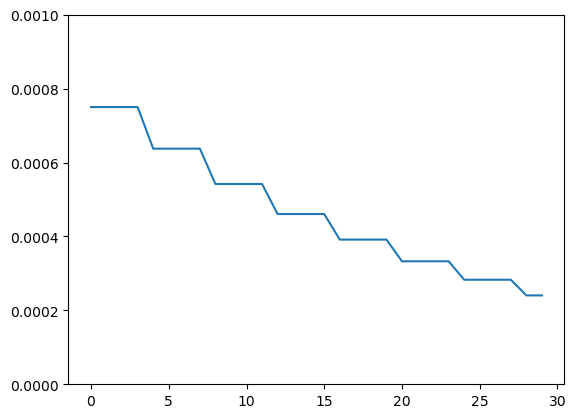

In [379]:
model = CovidCNN().to(device)


# apply learning rate decay
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=exp_gamma)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,2,4,6,8,12,16], gamma=0.85)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma=0.78)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma=0.75)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,12,16], gamma=0.65)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 6, gamma=0.85)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = lr_step_size, gamma=lr_gamma)



lrs = []
for i in range(30):
    # print(scheduler.get_last_lr())
    lrs.append(scheduler.get_last_lr())
    scheduler.step()
plt.plot(lrs)
plt.ylim([0,0.001])

### Perform Cross Validation

In [ ]:
total_history, fold_histories, models = train_k_fold(
    n_folds=n_folds,
    dataset=train_dataset,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    momentum=momentum,
    step_size=lr_step_size,
    gamma=lr_gamma,
)

In [381]:
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

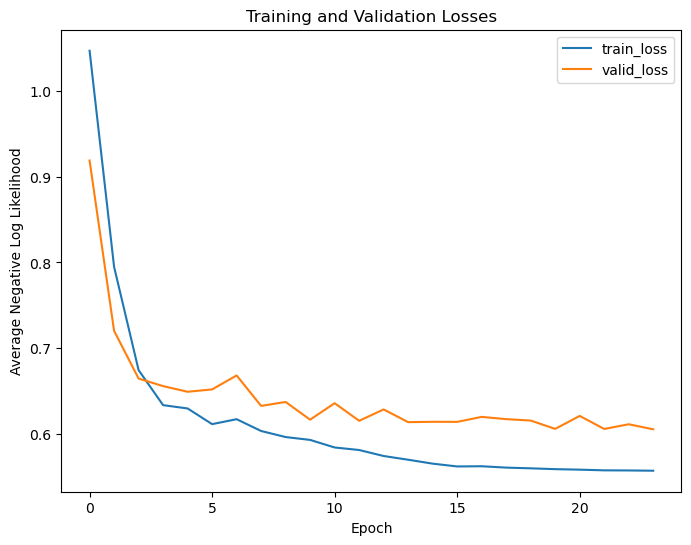

In [382]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        total_history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
# plt.savefig(f"{now}_loss.png")
plt.show()


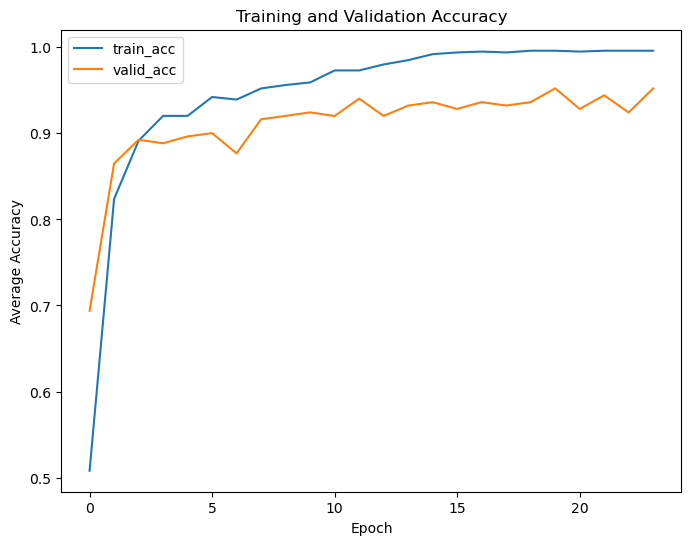

In [383]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        total_history[c]/100, label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
# plt.savefig(f"{now}_acc.png")
plt.show()


## Final Model Training

In [ ]:
device = torch.device(device_name)
# train final model based on experiments with hyperparameters performed during cross validation
model = CovidCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = lr_step_size, gamma=lr_gamma)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,2,5,10,15,20, 25], gamma=0.85)

# train final model on full train dataset without cross validation
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
val_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=5)

train_size = len(train_dataset)
val_size = len(test_dataset)

model, history, train_metrics = train_loop(
        model=model,
        num_epochs=num_epochs,
        train_data_loader=train_data_loader,
        train_size=train_size,
        val_data_loader=val_data_loader,
        val_size=val_size,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        fold=0,
        perform_val=True
    )

print(f'Training loss: {train_metrics[0]:.4f} and Training Accuracy: {train_metrics[1]:.2f}%')

In [370]:
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
history = pd.DataFrame(
        history,
        columns=['train_loss', 'test_loss', 'train_acc', 'test_acc'])

history

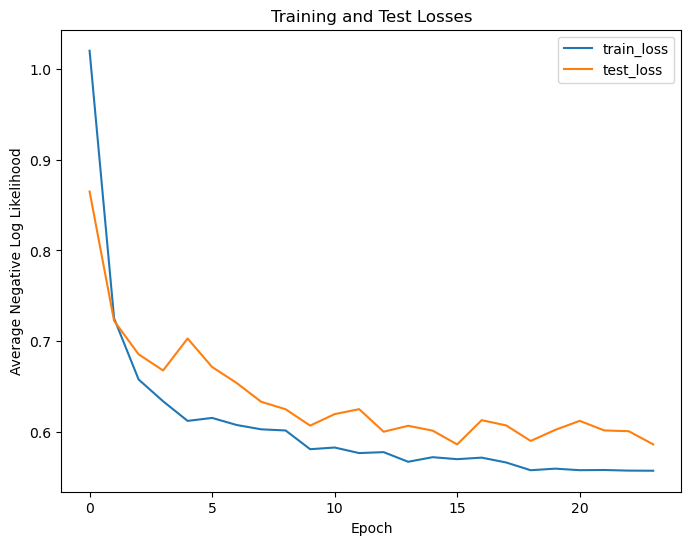

In [376]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'test_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Test Losses')
# plt.savefig(f"{now}_test_loss.png")
plt.show()


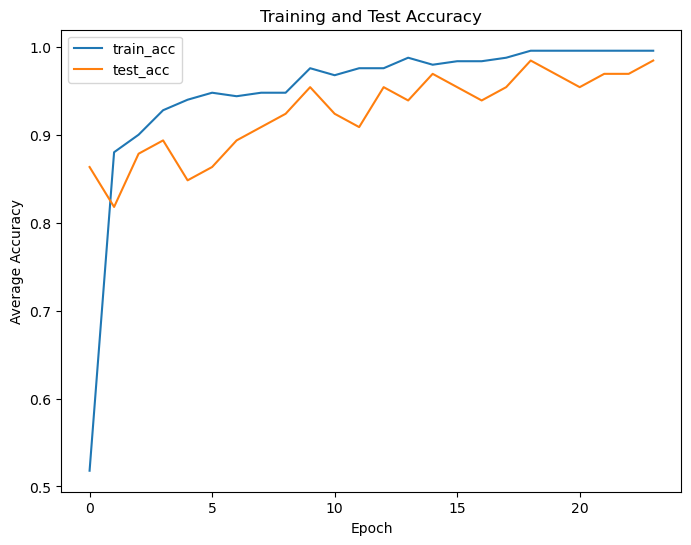

In [377]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'test_acc']:
    plt.plot(
        history[c]/100, label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Test Accuracy')
# plt.savefig(f"{now}_test_acc.png")
plt.show()

### Model Summary

In [19]:
device = torch.device('mps')
model = CovidCNN().to(device)

def count_parameters(model):
    table = PrettyTable(['Modules', 'Parameters'])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f'Total Trainable Params: {total_params}')
    return total_params

total_params = count_parameters(model)

NameError: name 'CovidCNN' is not defined